In [13]:
"""
This file contained the feature-based similarity search method using two-layer neural network

Created by Zexi Chen(zchen22)
Date: Oct 2, 2016
"""

import numpy
import six.moves.cPickle as pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from Feature_based_similarity_search import loadData, dtw, euclideanDist, NeuNet
%matplotlib inline

In [2]:
# read the data and rescale to 0-1
train_set = loadData('../theano/data/samples1')
valid_set = loadData('../theano/data/samples2')
test_set = loadData('../theano/data/samples3')

# reshape the array, concatenate two time series as one training instance
train_set_reshape = numpy.reshape(train_set, (train_set.shape[0]/2, train_set.shape[1]*2))
valid_set_reshape = numpy.reshape(valid_set, (valid_set.shape[0]/2, valid_set.shape[1]*2))
test_set_reshape = numpy.reshape(test_set, (test_set.shape[0]/2, test_set.shape[1]*2))

# re-scale input data
train_set1 = train_set_reshape/255.0
valid_set1 = valid_set_reshape/255.0
test_set1 = test_set_reshape/255.0

In [3]:
# calculate the squared dtw distance between the two time series in each row of the training data validation data and test data 
# the dtw is used in the cost function as the target value to minimize.
train_dtws = numpy.zeros((train_set1.shape[0],1))
for i in range(train_set1.shape[0]):
    train_dtws[i,0] = dtw(train_set1[i,0:23], train_set1[i,23:])**2

valid_dtws = numpy.zeros((valid_set1.shape[0],1))
for i in range(valid_set1.shape[0]):
    valid_dtws[i,0] = dtw(valid_set1[i,0:23], valid_set1[i,23:])**2

test_dtws = numpy.zeros((test_set1.shape[0],1))
for i in range(test_set1.shape[0]):
    test_dtws[i,0] = dtw(test_set1[i,0:23], test_set1[i,23:])**2

In [4]:
# build the neural network model
# start the tensorflow interaction interface
sess = tf.InteractiveSession()

In [49]:
n_hiddens = [100,10]
learning_rate = [1e-2]
training_epochs = 10000

# create two variable placehold, x for the training features, 
# y for the labels(in this model it is the dtw distance between two time series)
x = tf.placeholder(tf.float32, shape=[None, train_set1.shape[1]])
y = tf.placeholder(tf.float32, shape=[None, 1])

nn1 = NeuNet(
    None,
    None,
    input = x,
    activation = tf.nn.sigmoid,
    n_visible = train_set1.shape[1],
    n_hidden =  n_hiddens[0]
)

nn2 = NeuNet(
    None,
    None,
    input = nn1.output,
    activation = tf.nn.sigmoid,
    n_visible = n_hiddens[0]*2,
    n_hidden = n_hiddens[1]
)

In [50]:
# compute the cost and minimize it
cost = nn2.cost_function(y)
train_step = tf.train.AdamOptimizer(learning_rate[0]).minimize(cost)

sess.run(tf.initialize_all_variables())

In [51]:
# run the model
train_error = []
valid_error = []
best_valid_error = numpy.inf
for i in range(training_epochs):
    sess.run([train_step], feed_dict={x:train_set1, y:train_dtws})
    if i%100 == 0:
        train_err = sess.run([cost],feed_dict={x:train_set1, y:train_dtws})
        train_error.append(train_err)
        valid_err = sess.run([cost],feed_dict={x:valid_set1, y:valid_dtws})
        valid_error.append(valid_err)
        print("step %d, the mean error of the training data %g, vilidation data %g"%(i, train_error[-1][0], valid_error[-1][0]))
        #print h_conv1_flat.eval(feed_dict={x:test_set1})
        if valid_error[-1][0] < best_valid_error * 0.995:
            W_1 = sess.run(nn1.W)
            b_1 = sess.run(nn1.b)
            W_2 = sess.run(nn2.W)
            b_2 = sess.run(nn2.b)
            best_valid_error = valid_error[-1][0]

step 0, the mean error of the training data 16.554, vilidation data 16.3431
step 100, the mean error of the training data 6.68091, vilidation data 6.51247
step 200, the mean error of the training data 5.07931, vilidation data 5.24687
step 300, the mean error of the training data 4.72187, vilidation data 4.94978
step 400, the mean error of the training data 4.53294, vilidation data 4.81859
step 500, the mean error of the training data 4.37997, vilidation data 4.72571
step 600, the mean error of the training data 4.2631, vilidation data 4.66389
step 700, the mean error of the training data 4.11943, vilidation data 4.59007
step 800, the mean error of the training data 3.99915, vilidation data 4.52306
step 900, the mean error of the training data 3.87423, vilidation data 4.45973
step 1000, the mean error of the training data 3.73585, vilidation data 4.38818
step 1100, the mean error of the training data 3.606, vilidation data 4.30715
step 1200, the mean error of the training data 3.49004, 

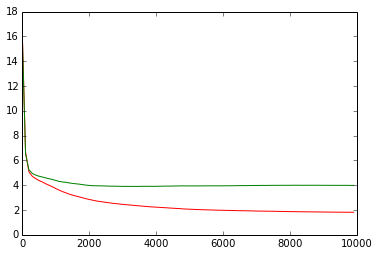

In [52]:
# plot the training error and validation error
Xaxis = [x * 100 for x in range(training_epochs/100)]
plt.plot(Xaxis, train_error, 'r',label='train error')
plt.plot(Xaxis, valid_error, 'g',label='validation error')
plt.show()

In [53]:
# rescale the test dataset
test_set_rescale = test_set/255.0

In [54]:
# reshape the W matrix to [23,10]
W_1_prime = numpy.reshape(W_1,[23, n_hiddens[0]])
hidden_1 = sess.run(tf.nn.sigmoid(numpy.matmul(test_set,W_1_prime)+b_1))
W_2_prime = numpy.reshape(W_2,[n_hiddens[0], n_hiddens[1]])
hidden_2 = tf.nn.sigmoid(numpy.matmul(hidden_1,W_2_prime)+b_2)

In [55]:
test_features = sess.run(hidden_2)

In [70]:
test_features

array([[  1.16397669e-07,   1.31777271e-03,   1.99405509e-01, ...,
          9.99999978e-01,   1.00000000e+00,   7.76016295e-06],
       [  7.47261553e-04,   3.82610180e-04,   9.99999977e-01, ...,
          1.00000000e+00,   9.99999996e-01,   7.78138190e-01],
       [  1.87070623e-09,   3.24778967e-14,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   9.64337943e-01],
       ..., 
       [  9.96187019e-01,   9.52355797e-01,   9.99999980e-01, ...,
          1.00000000e+00,   9.99991521e-01,   9.99999586e-01],
       [  3.34437230e-03,   8.62445490e-11,   2.65457901e-02, ...,
          4.89121225e-08,   1.00000000e+00,   1.85822076e-04],
       [  1.97823723e-14,   1.91019661e-12,   1.00000000e+00, ...,
          9.10287052e-01,   1.00000000e+00,   6.36816465e-01]])

In [61]:
# for one time series in test dataset, calculate its distance with 1000 time series in test dataset
euclidean_dists = []
dtw_dists = []
for i in range(1000):
    dtw_dists.append((i,dtw(test_set_rescale[i], test_set_rescale[-3])))
    euclidean_dists.append((i, euclideanDist(test_features[i], test_features[-3])))

In [62]:
# sort the result
euclidean_dists_sorted = sorted(euclidean_dists, key=(lambda x: x[1]))
dtw_dists_sorted = sorted(dtw_dists, key=(lambda x: x[1]))

In [63]:
euclidean_dists_sorted[:20]

[(137, 0.048786173385465925),
 (979, 0.04947798180306272),
 (951, 0.050912793021390956),
 (617, 0.052762406541472545),
 (947, 0.054013142361485356),
 (616, 0.0542590919779111),
 (193, 0.054457731611809904),
 (998, 0.05474820947396863),
 (219, 0.05546584005742464),
 (292, 0.057448826870309735),
 (327, 0.057695249458845986),
 (459, 0.05917192932128024),
 (749, 0.0644046344740277),
 (143, 0.06794457990333636),
 (456, 0.06821947028059804),
 (231, 0.0682349685141227),
 (743, 0.07601540057423666),
 (689, 0.0771653073653056),
 (74, 0.07912596342578367),
 (417, 0.0797564657142975)]

In [64]:
dtw_dists_sorted[:20]

[(908, 0.992156862745098),
 (168, 1.0274509803921568),
 (872, 1.0745098039215686),
 (846, 1.0901960784313725),
 (842, 1.164705882352941),
 (81, 1.1803921568627447),
 (80, 1.223529411764706),
 (847, 1.2549019607843137),
 (584, 1.2705882352941178),
 (843, 1.3098039215686272),
 (153, 1.329411764705882),
 (163, 1.333333333333333),
 (169, 1.3333333333333333),
 (299, 1.4196078431372545),
 (342, 1.4196078431372547),
 (799, 1.4313725490196079),
 (553, 1.4901960784313717),
 (575, 1.490196078431373),
 (552, 1.494117647058823),
 (433, 1.4980392156862743)]

In [65]:
# take out 100 neighbors using both euclidean distance and dtw distance. 
# See the number of the overlap neighbors between them
euclid_set = set()
dtw_set = set()
for i in range(100):
    euclid_set.add(euclidean_dists_sorted[i][0])
    dtw_set.add(dtw_dists_sorted[i][0])
count = 0
for x in euclid_set:
    if x in dtw_set:
        count += 1
print count

17
